# MNIST

In this example, we'll demonstrate how to use [dataduit](https://github.com/JackBurdick/dataduit) to create tensorflow datasets from the readily available tfdataset by specifying a config file.

We'll then demonstrate how to use yeahml to create/build/evaluate a model on the created data.

#### Note:
> The model for this project likely doesn't make sense. I am not personally familiar with the dataset/problem, I was interested showing an example

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# import pandas as pd
import tensorflow as tf
import dataduit as dd
import yeahml as yml

<IPython.core.display.Javascript object>

## Create Datasets

In [3]:
# only use 2 of the features
dd_dict = {
    "meta": {
        "name": "mnist",
        "logging": {"log_stream_level": "INFO"},
        "in": {"from": "online", "type": "tfd"},
    },
    "read": {
        "split_percents": [75, 15, 10],
        "split_names": ["train", "val", "test"],
        "from_stage": "preprocessed",
    },
}

<IPython.core.display.Javascript object>

In [4]:
# create the datasets based on the above defined names/splits/specifed data
ds_dict_raw = dd.read(dd_dict)[0]

root dir set to None
as_supervised set to False
with_info set to False


<IPython.core.display.Javascript object>

## alter dataset

In [5]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255.0, label

<IPython.core.display.Javascript object>

In [6]:
def load_image(datapoint):

    input_image, input_mask = normalize_img(datapoint["image"], datapoint["label"])

    return input_image, input_mask

<IPython.core.display.Javascript object>

In [7]:
for k, cur_ds in ds_dict_raw.items():

    cur_ds = cur_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    ds_dict_raw[k] = cur_ds

<IPython.core.display.Javascript object>

In [8]:
ds_dict = {"mnist": ds_dict_raw}

<IPython.core.display.Javascript object>

`ds_dict` is a dictionary containing the tensorflow datasets (as specified above). which can be accessed like this:

```python
ds_val = ds_dict["val"]
```

## subset

In [9]:
sample_size = 1000
for ds_name, cur_dict in ds_dict.items():
    for split_name, split_ds in cur_dict.items():
        ds_dict[ds_name][split_name] = split_ds.take(sample_size)

<IPython.core.display.Javascript object>

## Specify the Model

In [10]:
example = "./main_config.yml"
yml_dict = yml.create_configs(example)

config_logger: INFO     directory yeahml/mnist/trial_00/model_a removed
config_logger: INFO     directory yeahml/mnist/trial_00/model_a created


<IPython.core.display.Javascript object>

## Build the model

In [11]:
# If you receive an error:
# AttributeError: 'google.protobuf.pyext._message.RepeatedCompositeCo' object has no attribute 'append'
# I personally used `pip install -U protobuf=3.8.0` to resolve
# per https://github.com/tensorflow/tensorflow/issues/33348
model = yml.build_model(yml_dict)

build_logger: INFO     -> START building graph
build_logger: INFO     information json file created


<IPython.core.display.Javascript object>

In [12]:
model.summary()

Model: "model_a"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
x_image (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 8)         80        
_________________________________________________________________
conv_2_downsample (Conv2D)   (None, 14, 14, 8)         584       
_________________________________________________________________
conv_3 (Conv2D)              (None, 14, 14, 8)         584       
_________________________________________________________________
conv_4_downsample (Conv2D)   (None, 7, 7, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 392)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               5030

<IPython.core.display.Javascript object>

## Train the Model

Notice here that we're using the created training and validation sets from `ds_dict`

In [13]:
ds_dict

{'mnist': {'train': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'val': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>,
  'test': <TakeDataset shapes: ((28, 28, 1), ()), types: (tf.float32, tf.int64)>}}

<IPython.core.display.Javascript object>

In [14]:
yml_dict["performance"]["objectives"]

{'main_obj': {'loss': {'type': 'sparse_categorical_crossentropy',
   'options': [None],
   'track': ['mean']},
  'metric': {'type': ['sparsecategoricalaccuracy'], 'options': [None]},
  'in_config': {'type': 'supervised',
   'options': {'prediction': 'y_pred', 'target': 'y_target'},
   'dataset': 'mnist'}}}

<IPython.core.display.Javascript object>

In [15]:
%%time
# roughly 69 seconds vs 116 seconds 5 epoch mnist -- not a real benchmark (23April19)
# roughly 69 seconds vs 101 seconds 5 epoch mnist -- not a real benchmark (24April19)
train_dict = yml.train_model(model, yml_dict, ds_dict)

train_logger: INFO     START - training
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 1
train_logger: INFO     done inference on val - 992
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 2
train_logger: INFO     done inference on val - 1984
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 3
train_logger: INFO     done inference on val - 2976
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 4
train_logger: INFO     done inference on val - 3968
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 5
train_logger: INFO     done inference on val - 4

CPU times: user 11.3 s, sys: 1.77 s, total: 13.1 s
Wall time: 10.2 s


<IPython.core.display.Javascript object>

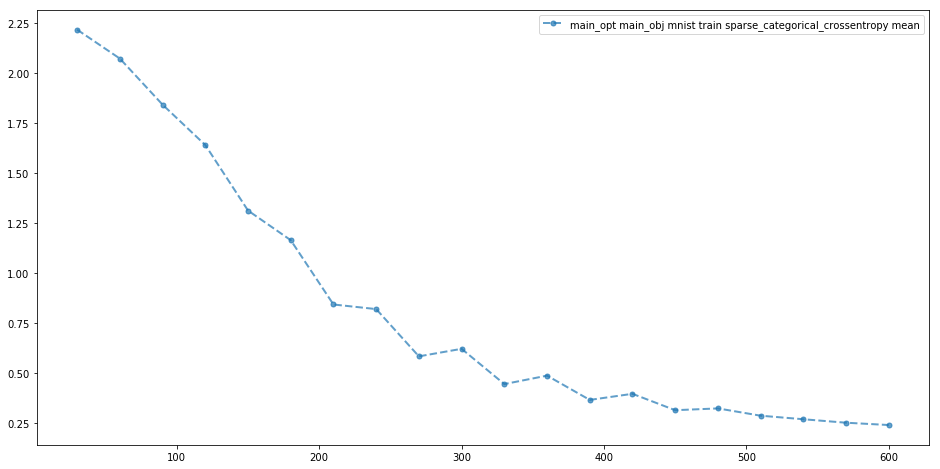

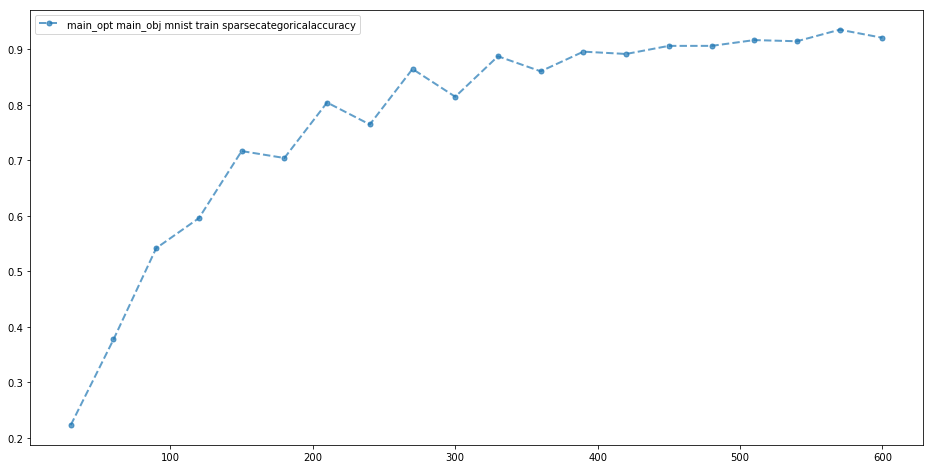

<IPython.core.display.Javascript object>

In [16]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=True,
    validation=False,
    loss=True,
    size=(16, 8),
)

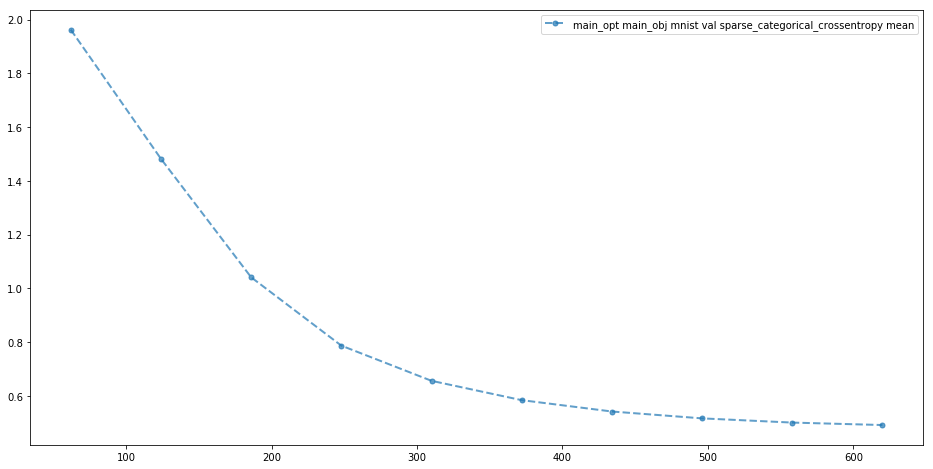

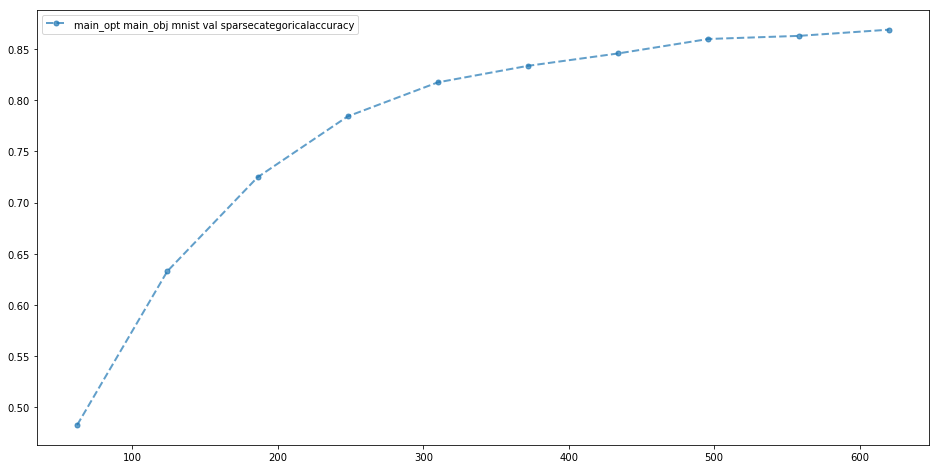

<IPython.core.display.Javascript object>

In [17]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=False,
    validation=True,
    loss=True,
    size=(16, 8),
)

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>

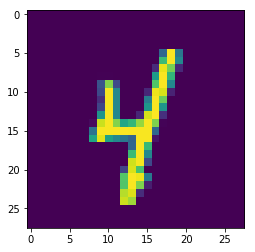

target: 4, prediction: 4


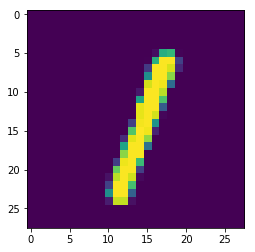

target: 1, prediction: 1


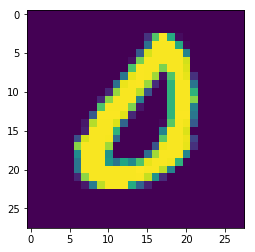

target: 0, prediction: 0


<IPython.core.display.Javascript object>

In [19]:
for in_example in ds_dict["mnist"]["train"].take(3):
    x = tf.squeeze(in_example[0])
    plt.imshow(x)
    plt.show()
    pred_softmax = model(tf.expand_dims(in_example[0], 0))
    pred = tf.argmax(pred_softmax, 1)
    print(f"target: {in_example[1]}, prediction: {pred[0]}")

In [20]:
eval_dict = yml.eval_model(
    model,
    yml_dict,
    ds_dict,
    eval_split="test",
    pred_dict={
        "pred": {"fn": tf.argmax, "options": {"axis": 1}},
        "write": None,
    },  # hacky first cut
)

eval_logger : INFO     START - evaluating
eval_logger : INFO     current dataset: mnist
eval_logger : INFO     in_hash: -8170597107930176485
eval_logger : INFO     current config: {'type': 'supervised', 'options': {'prediction': 'y_pred', 'target': 'y_target'}, 'dataset': 'mnist'}
eval_logger : INFO     done inference_on_ds on test


<IPython.core.display.Javascript object>

In [21]:
for in_hash in eval_dict["mnist"].keys():
    print(eval_dict["mnist"][in_hash]["loss"])

{'sparse_categorical_crossentropy': {'loss_main_obj_sparse_categorical_crossentropy_mean_test': 0.4436243}}


<IPython.core.display.Javascript object>

In [22]:
for in_hash in eval_dict["mnist"].keys():
    print(eval_dict["mnist"][in_hash]["metrics"])

{'sparse_categorical_accuracy': 0.8780242}


<IPython.core.display.Javascript object>

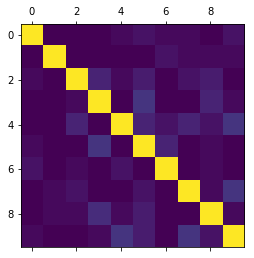

<IPython.core.display.Javascript object>

In [23]:
in_hash = list(eval_dict["mnist"].keys())[0]
cm = confusion_matrix(
    eval_dict["mnist"][in_hash]["out"]["pred"],
    eval_dict["mnist"][in_hash]["out"]["target"],
)
plt.matshow(cm, vmin=0, vmax=40)
plt.show()

## experimental

In [24]:
import tensorflow_model_optimization as tfmot

<IPython.core.display.Javascript object>

In [25]:
cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

<IPython.core.display.Javascript object>

In [26]:
clustering_params = {
    "number_of_clusters": 16,
    "cluster_centroids_init": CentroidInitialization.LINEAR,
}

<IPython.core.display.Javascript object>

In [27]:
clustered_model = cluster_weights(model, **clustering_params)

<IPython.core.display.Javascript object>

In [28]:
%%time
# TODO: only finetune
train_dict = yml.train_model(clustered_model, yml_dict, ds_dict)

train_logger: INFO     START - training
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 1
train_logger: INFO     done inference on val - 992
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 2
train_logger: INFO     done inference on val - 1984
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 3
train_logger: INFO     done inference on val - 2976
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 4
train_logger: INFO     done inference on val - 3968
train_logger: INFO     optimizer: main_opt
train_logger: INFO     objective: main_obj
train_logger: INFO     epoch main_obj - mnist train: 5
train_logger: INFO     done inference on val - 4

CPU times: user 16.2 s, sys: 1.18 s, total: 17.4 s
Wall time: 12.4 s


<IPython.core.display.Javascript object>

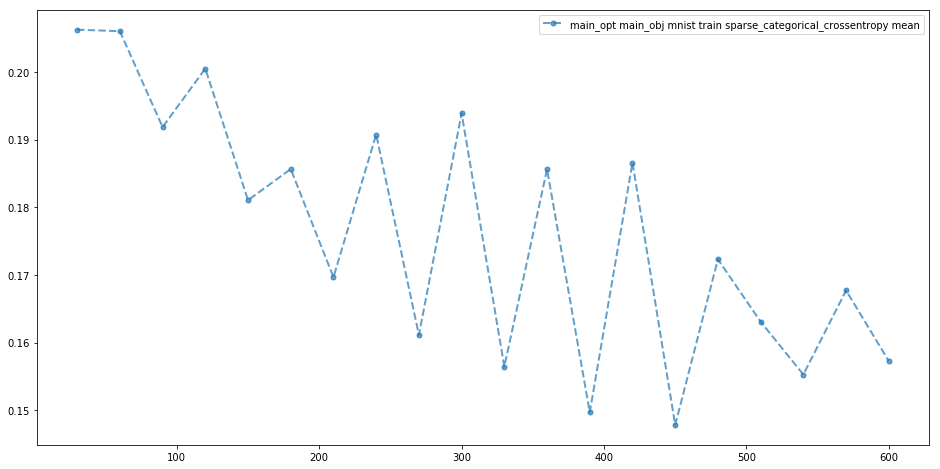

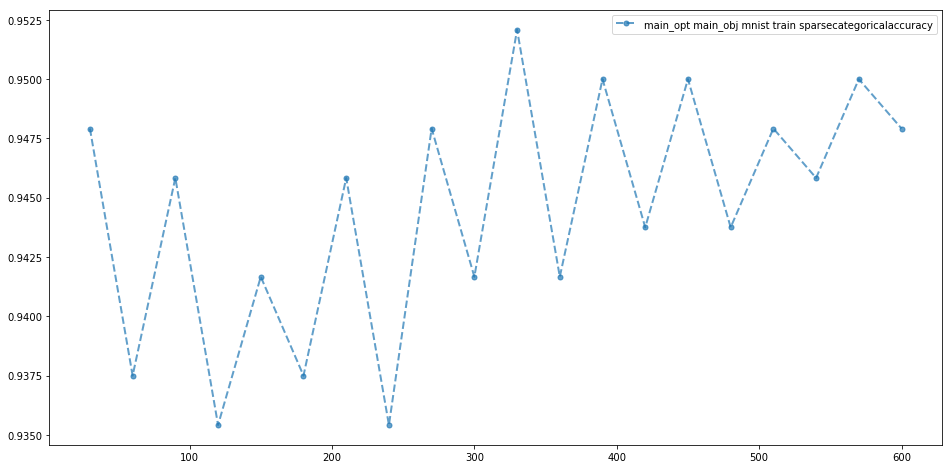

<IPython.core.display.Javascript object>

In [29]:
yml.basic_plot_tracker(
    train_dict["tracker"],
    metrics=True,
    local=False,
    training=True,
    validation=False,
    loss=True,
    size=(16, 8),
)

## Evaluate the Model

In [30]:
# eval_dict = yml.eval_model(
#     model,
#     yml_dict,
#     dataset=ds_dict["test"]
# )
# print(eval_dict)

<IPython.core.display.Javascript object>

## Inspect model in Tensorflow

In the command line you can navigate to the `albalone` directory and run: (provided tensorboard is installed in your environment)

```bash
tensorboard --logdir model_a/
```